<a href="https://colab.research.google.com/github/RuthKassahun/Melanoma_Classification/blob/main/Vgg_16_transfer_learning_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:05<00:00, 196MB/s]
100% 1.06G/1.06G [00:05<00:00, 197MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 1s 0us/step


In [3]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/MultiClass_Skin_lesion/train/',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/MultiClass_Skin_lesion/val/',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 5082 files belonging to 3 classes.
Found 1270 files belonging to 3 classes.


In [9]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [16]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.6 MB/s eta 0:00:00


In [22]:
import tensorflow_addons as tfa

In [23]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy',tfa.metrics.CohenKappa(num_classes=3, sparse_labels=True)]
  )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
159/159 [==============================] - 779s 5s/step - loss: 0.4855 - accuracy: 0.6592 - cohen_kappa: 0.0000e+00 - val_loss: 0.4135 - val_accuracy: 0.7559 - val_cohen_kappa: 0.0000e+00
Epoch 2/10
159/159 [==============================] - 59s 356ms/step - loss: 0.3689 - accuracy: 0.7536 - cohen_kappa: 0.0000e+00 - val_loss: 0.3545 - val_accuracy: 0.7748 - val_cohen_kappa: 0.0000e+00
Epoch 3/10
159/159 [==============================] - 53s 323ms/step - loss: 0.3007 - accuracy: 0.7621 - cohen_kappa: 0.0000e+00 - val_loss: 0.2766 - val_accuracy: 0.7504 - val_cohen_kappa: 0.0000e+00
Epoch 4/10
159/159 [==============================] - 53s 321ms/step - loss: 0.2397 - accuracy: 0.7666 - cohen_kappa: 0.0000e+00 - val_loss: 0.2755 - val_accuracy: 0.7992 - val_cohen_kappa: 0.0000e+00
Epoch 5/10
159/159 [==============================] - 53s 323ms/step - loss: 0.1760 - accuracy: 0.7806 - cohen_kappa: 0.0000e+00 - val_loss: 0.2268 - val_accuracy: 0.7969 - val_cohen_kappa: 0.0000e+

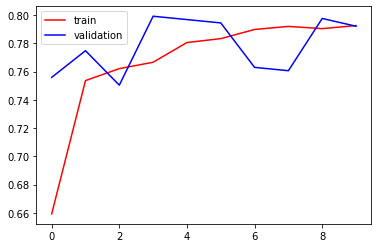

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

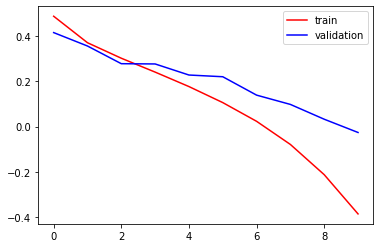

In [26]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()